<a href="https://colab.research.google.com/github/bkleck/BERT/blob/main/bert_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT
### Bidirectional Encoder Representations from Transformers
Why BERT?

BERT encodes the words before and after the selected word, hence retaining more context of the sentence. 

BERT also makes use of masking (hiding 15% of words), thus the model is better able to predict words within a sentence.

BERT also makes use of transformer's attention mechanism, enabling the model to have longer memory and retain context from previous tokens.



# Import required libraries
- Download pre-trained model from tensorflow hub

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install bert-tensorflow==1.0.1
!pip install tensorflow==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.9 MB/s 
  Attempting uninstall: bert-tensorflow
    Found existing installation: bert-tensorflow 1.0.4
    Uninstalling bert-tensorflow-1.0.4:
      Successfully uninstalled bert-tensorflow-1.0.4


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)

In [ ]:
import bert
from bert import tokenization
# BERT uncased, 12 hidden layers, 768 hidden size, 12 attention heads
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
root_path = '/content/gdrive/MyDrive/Tech Sharing - Boon Kong/'

# Data Cleaning
Firstly, we will split all the reviews into sentences.

In [ ]:
# split into sentences
df = pd.read_csv(f'{root_path}reviews.csv')
df['comments'] = df['comments'].astype(str)
df['sentences'] = df['comments'].apply(lambda x: x.split('.'))
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentences
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,"[Cute and cozy place, Perfect location to eve..."
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,[Kelly has a great room in a very central loca...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...","[Very spacious apartment, and in a great neigh..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,[Close to Seattle Center and all it has to off...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,[Kelly was a great host and very accommodating...


In [ ]:
# make each sentence into its own row
s = df.apply(lambda x: pd.Series(x['sentences']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'sentence'
df = df.drop('sentences', axis=1).join(s)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Cute and cozy place
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Perfect location to everything!
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,Kelly has a great room in a very central location
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,"\r\nBeautiful building , architecture and a s..."
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,\r\nWe felt guite at home here and wish we ha...


In [ ]:
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now, we will clean the data to the form which is required by the BERT model.

In [ ]:
## functions for cleaning tasks

def remove_punct(text):
    no_punct = ''.join(char for char in text if char not in string.punctuation)
    return no_punct

df['sentence'] = df['sentence'].apply(lambda x: remove_punct(x))

# remove rows with less than 3 words
df = df[~df['sentence'].str.split().str.len().lt(3)]

#remove irrelevant symbols
df['sentence'] = df['sentence'].replace('\n','', regex=True)
df['sentence'] = df['sentence'].replace('\r','', regex=True)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Cute and cozy place
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Perfect location to everything
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,Kelly has a great room in a very central location
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,Beautiful building architecture and a style ...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,We felt guite at home here and wish we had sp...


Now, we will shuffle the dataset to randomize the train and test sets in order to be more representative of our data.

In [ ]:
from sklearn.utils import shuffle
# shuffle dataframe
df = shuffle(df)
df.to_csv(f'{root_path}full_reviews.csv')

# take out 1000 data points for labelling
sample_df = df[0:2000]
sample_df.to_csv(f'{root_path}sample_reviews.csv')

We will be labelling the sample dataframe obtained from above. These are the labels:

-1 = negative

0 = neutral

1 = positive

# Build BERT model

In [ ]:
df = pd.read_csv(f'{root_path}labelled_reviews.csv', index_col=[0])
df.dropna(inplace=True)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,sentiment
60914,2628010,26653805,2015-02-16,15099213,Brighton,"Great neighborhood, beautiful condo! Lots of ...",Parking was a bit tough but we found that we c...,-1
39012,4349344,28471811,2015-03-24,12867508,Megan,The place was simply gorgeous. The location wa...,The location was perfect The ambiance was defi...,1
34310,1950446,38598530,2015-07-17,13069740,Samuel,"Entry/exit really easy. Apartment was clean, ...",Entryexit really easy,1
39468,3401644,28907118,2015-03-31,29562829,Chrissy,This apartment is in a very quiet and safe res...,Overall I loved staying in a quiet neighborhoo...,1
43606,59827,50648020,2015-10-13,6454365,Cathy,Fantastic stay at Darik's apartment! We had a ...,My husband and I slept on the pullout couch wh...,0


In [ ]:
# tf.utils.to_categorical only supports integers from 0 to num_classes
# need to map sentiment values
def map(row):
  mapping = {-1:0, 0:1, 1:2}
  for k,v in mapping.items(): 
    if k == row:
      return v

# now 0 is negative, 1 is neutral, 2 is positive
df['label'] = df['sentiment'].apply(lambda x: map(x))
df.dropna(inplace=True)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,sentiment,label
60914,2628010,26653805,2015-02-16,15099213,Brighton,"Great neighborhood, beautiful condo! Lots of ...",Parking was a bit tough but we found that we c...,-1,0
39012,4349344,28471811,2015-03-24,12867508,Megan,The place was simply gorgeous. The location wa...,The location was perfect The ambiance was defi...,1,2
34310,1950446,38598530,2015-07-17,13069740,Samuel,"Entry/exit really easy. Apartment was clean, ...",Entryexit really easy,1,2
39468,3401644,28907118,2015-03-31,29562829,Chrissy,This apartment is in a very quiet and safe res...,Overall I loved staying in a quiet neighborhoo...,1,2
43606,59827,50648020,2015-10-13,6454365,Cathy,Fantastic stay at Darik's apartment! We had a ...,My husband and I slept on the pullout couch wh...,0,1


In [ ]:
# Split into train and test 
train, test = train_test_split(df, test_size = 0.3)

## Encoder
We do not have to encode the words into tokens as the BERT model will be able to do that for us.

We will create tokens + masks + segments.

In [ ]:
tf.gfile = tf.io.gfile # prevent versioning issue from TF 1 to TF 2
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"] # specify start and end of sentence
        pad_len = max_len - len(input_sequence) # pad shorter sentences to same length
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

## Build Model
We will be keeping the BERT architecture as the base model, building layers on top to perform classification into the output required (sentiment).

Categorical accuracy is used instead of accuracy for stricter training. Furthermore, as our input data is very biased (many positive reviews), lower-represented categories need to have equal weights.



In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    # this is the BERT layer
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    # build a neural network on top of BERT to perform classification
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net) # randomly drop 20% of data to help model learn better
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net) # softmax helps to find the category with highest probability

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [ ]:
max_len = 150 # length of the longest sentence in our dataset
train_input = bert_encode(train.sentence.values, tokenizer, max_len=max_len)
test_input = bert_encode(test.sentence.values, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(train.label.values, num_classes=3)

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_categorical_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5, verbose=1) # stop training early if performance does not improve
tf.config.run_functions_eagerly(True)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=20,
    callbacks=[checkpoint, earlystopping],
    batch_size=16,
    verbose=1)

model.save(f'{root_path}model.h5')

Epoch 1/20
70/70 [==============================] - 50s 600ms/step - loss: 0.6994 - categorical_accuracy: 0.7589 - val_loss: 0.4786 - val_categorical_accuracy: 0.8250

Epoch 00001: val_categorical_accuracy improved from -inf to 0.82500, saving model to model.h5
Epoch 2/20
70/70 [==============================] - 43s 618ms/step - loss: 0.4203 - categorical_accuracy: 0.8616 - val_loss: 0.3663 - val_categorical_accuracy: 0.8607

Epoch 00002: val_categorical_accuracy improved from 0.82500 to 0.86071, saving model to model.h5
Epoch 3/20
70/70 [==============================] - 41s 586ms/step - loss: 0.3163 - categorical_accuracy: 0.8929 - val_loss: 0.3290 - val_categorical_accuracy: 0.9000

Epoch 00003: val_categorical_accuracy improved from 0.86071 to 0.90000, saving model to model.h5
Epoch 4/20
70/70 [==============================] - 43s 616ms/step - loss: 0.2548 - categorical_accuracy: 0.9179 - val_loss: 0.3685 - val_categorical_accuracy: 0.8786

Epoch 00004: val_categorical_accuracy di

We achieved a categorical accuracy of 90% on our train dataset.

# Predict on Test Set

In [ ]:
# load the trained weights to perform classification on test set
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [ ]:
list1 = test_pred.tolist()

test['label_pred'] = list1
test.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,sentiment,label,label_pred
26309,7500728,41471680,2015-08-07,39483201,Michael,"Very cute, clean and comfortable! After a bit ...",The neighborhood is quiet and working class in...,1,2,"[0.00045694902655668557, 0.0014326547970995307..."
61676,4973204,37079230,2015-07-04,3798922,Franck,"Ben was a really great host. First, I have to ...",Theres a few buses close by you can walk from ...,1,2,"[0.0016659068642184138, 0.008702337741851807, ..."
74958,580815,12084811,2014-04-22,5216961,Lauren,This apartment was perfect for vacation. It ha...,Its in a big residential building with a groce...,1,2,"[0.022325294092297554, 0.6309372186660767, 0.3..."
10175,387464,23322039,2014-11-29,939483,Annelliott,This was the perfect solution to a crowded hou...,It went off without a hitch and unlike most re...,-1,0,"[0.6835945844650269, 0.26634690165519714, 0.05..."
2557,4430381,31089518,2015-05-01,32130332,Derek,The reservation was canceled 14 days before ar...,This is an automated posting,0,1,"[0.04909210652112961, 0.9076144099235535, 0.04..."


In [ ]:
# encode predictions into labels
# first element is for positive
# second element is for neutral
# last element is for negative
def encode(row):
  i = row[0]
  if round(i) == 0:
    val = 1
  elif round(i) == 1:
    val = 0
  else:
    val = -1
  return val

In [ ]:
test['sentiment_pred'] = test['label_pred'].apply(lambda x: encode(x))
test.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,sentiment,label,label_pred,sentiment_pred
26309,7500728,41471680,2015-08-07,39483201,Michael,"Very cute, clean and comfortable! After a bit ...",The neighborhood is quiet and working class in...,1,2,"[0.00045694902655668557, 0.0014326547970995307...",1
61676,4973204,37079230,2015-07-04,3798922,Franck,"Ben was a really great host. First, I have to ...",Theres a few buses close by you can walk from ...,1,2,"[0.0016659068642184138, 0.008702337741851807, ...",1
74958,580815,12084811,2014-04-22,5216961,Lauren,This apartment was perfect for vacation. It ha...,Its in a big residential building with a groce...,1,2,"[0.022325294092297554, 0.6309372186660767, 0.3...",1
10175,387464,23322039,2014-11-29,939483,Annelliott,This was the perfect solution to a crowded hou...,It went off without a hitch and unlike most re...,-1,0,"[0.6835945844650269, 0.26634690165519714, 0.05...",0
2557,4430381,31089518,2015-05-01,32130332,Derek,The reservation was canceled 14 days before ar...,This is an automated posting,0,1,"[0.04909210652112961, 0.9076144099235535, 0.04...",1


In [ ]:
print('Test accuracy is {}'.format(accuracy_score(test['sentiment'], test['sentiment_pred'])))

Test accuracy is 0.8816666666666667


We achieved an accuracy of 88% on our test dataset.

This is quite a good result given that we only used 2000 labelled dataset for our training, and also given the imbalance within our data. 

# Predict on Full Data

In [ ]:
full = pd.read_csv(f'{root_path}full_reviews.csv')
full.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence
0,60914,2628010,26653805,2015-02-16,15099213,Brighton,"Great neighborhood, beautiful condo! Lots of ...",Parking was a bit tough but we found that we c...
1,39012,4349344,28471811,2015-03-24,12867508,Megan,The place was simply gorgeous. The location wa...,The location was perfect The ambiance was def...
2,34310,1950446,38598530,2015-07-17,13069740,Samuel,"Entry/exit really easy. Apartment was clean, ...",Entryexit really easy
3,39468,3401644,28907118,2015-03-31,29562829,Chrissy,This apartment is in a very quiet and safe res...,Overall I loved staying in a quiet neighborh...
4,43606,59827,50648020,2015-10-13,6454365,Cathy,Fantastic stay at Darik's apartment! We had a ...,My husband and I slept on the pullout couch w...


Due to the large size of the reviews dataset, we will show our predictions using only 10k data points.

In [ ]:
full = full[0:10000]

In [ ]:
full_input = bert_encode(full.sentence.values, tokenizer, max_len=max_len)
print('Encoding finished!')
model.load_weights('model.h5')
full_pred = model.predict(full_input)
print('Prediction finished!')

list2 = full_pred.tolist()
full['label_pred'] = list2
full['sentiment_pred'] = full['label_pred'].apply(lambda x: encode(x))
full.head()

Encoding finished!
Prediction finished!


,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,label_pred,sentiment_pred
0,60914,2628010,26653805,2015-02-16,15099213,Brighton,"Great neighborhood, beautiful condo! Lots of ...",Parking was a bit tough but we found that we c...,"[0.9364829659461975, 0.059939321130514145, 0.0...",0
1,39012,4349344,28471811,2015-03-24,12867508,Megan,The place was simply gorgeous. The location wa...,The location was perfect The ambiance was def...,"[5.0380800530547276e-05, 0.0006052001263014972...",1
2,34310,1950446,38598530,2015-07-17,13069740,Samuel,"Entry/exit really easy. Apartment was clean, ...",Entryexit really easy,"[0.0007595145143568516, 0.007971464656293392, ...",1
3,39468,3401644,28907118,2015-03-31,29562829,Chrissy,This apartment is in a very quiet and safe res...,Overall I loved staying in a quiet neighborh...,"[8.711163536645472e-05, 0.0010205168509855866,...",1
4,43606,59827,50648020,2015-10-13,6454365,Cathy,Fantastic stay at Darik's apartment! We had a ...,My husband and I slept on the pullout couch w...,"[0.0002895306097343564, 0.007930790074169636, ...",1


In [ ]:
full.to_csv('final_reviews.csv')

# Visualize results

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
pos = full[full['sentiment_pred'] == 1]
pos.shape

(9430, 10)

In [ ]:
neg = full[full['sentiment_pred'] == 0]
neg.shape

(570, 10)

## positive word cloud

In [ ]:
text = pos.sentence.tolist()
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,width = 2000, height = 2000,
                      collocations=True,background_color='salmon', 
                      colormap='Pastel1').generate(text)

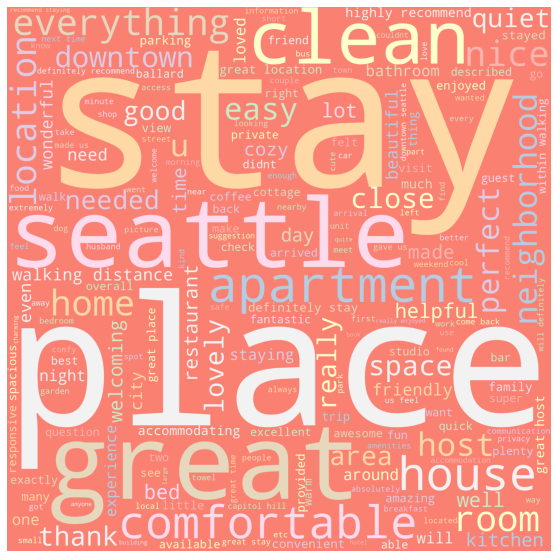

In [ ]:
#plot the wordcloud object
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(wordcloud)

## negative word cloud

In [ ]:
text = neg.sentence.tolist()
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,width = 2000, height = 2000,
                      collocations=True).generate(text)

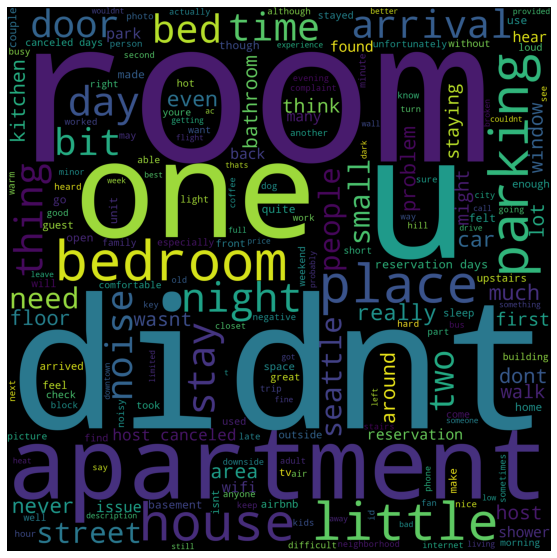

In [ ]:
#plot the wordcloud object
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(wordcloud)

- As shown, the word clouds contain the most common words for positive and negative reviews.